中期之后调整框架如下：

- data retreival
- data processing and feature engineering
- model and baseline model
- training and testing

# Data Retreival

服务器中磁盘取数（本地省略代码）

小规模样本选择：
- 散户主导组：选取创业板市值最小的10只股票（流通市值<50亿，个人投资者持股占比>40%，可通过深交所信息披露平台查询）。
- 机构主导组：选取沪深300中机构持股比例>70%的10只股票（上交所/深交所定期报告）。

# Data Processing and Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time
from datetime import datetime
from multiprocessing import Pool, cpu_count

import utils as _U

In [6]:
# 中证A50成分股
# 信息来源：东方财富 20250324
code_list = [
    # '688981sh', '603993sh', '603259sh', '601899sh', '601888sh', 
    # '601816sh', '601766sh', '601668sh', '601600sh', '601318sh', 
    # '601088sh', '601012sh', '600900sh', '600893sh', 
    # '600887sh', '600660sh', '600585sh', '600519sh', '600436sh', 
    # '600426sh', '600415sh', '600406sh', '600309sh', '600276sh', 
    '600176sh', '600036sh', '600031sh', '600030sh', '600028sh', 
    '600019sh', '600009sh', '300760sz', '300750sz', '300408sz', 
    # '300124sz', '300122sz', '300015sz', '002714sz', '002594sz', 
    # '002475sz', '002371sz', '002230sz', '002027sz', '000938sz', 
    # '000792sz', '000725sz', '000333sz', '000063sz', '000002sz'
    ]  

In [22]:
REC_CNT=20
PRED_CNT=5
is_linear=False
is_binary=True

In [19]:
df = pd.read_csv('data_202111/' + '600176sh.csv')
df.shape, df.columns

((104492, 69),
 Index(['datetime', 'Exchflg', 'Code', 'Code_Mkt', 'Qdate', 'QTime',
        'InstrumentStatus', 'Trdirec', 'PrevClPr', 'OpPr', 'HiPr', 'LoPr',
        'Tprice', 'Tvolume', 'Tsum', 'Tdeals', 'TVolume_accu', 'TSum_accu',
        'Tdeals_accu', 'TotBidVol', 'WghtAvgBidPr', 'TotAskVol', 'WghtAvgAskPr',
        'Absspread', 'Respread', 'Abseffspread', 'Reeffspread', 'Depth1',
        'Depth2', 'BidPr1', 'BidVol1', 'AskPr1', 'AskVol1', 'BidPr2', 'BidVol2',
        'AskPr2', 'AskVol2', 'BidPr3', 'BidVol3', 'AskPr3', 'AskVol3', 'BidPr4',
        'BidVol4', 'AskPr4', 'AskVol4', 'BidPr5', 'BidVol5', 'AskPr5',
        'AskVol5', 'BidPr6', 'BidVol6', 'AskPr6', 'AskVol6', 'BidPr7',
        'BidVol7', 'AskPr7', 'AskVol7', 'BidPr8', 'BidVol8', 'AskPr8',
        'AskVol8', 'BidPr9', 'BidVol9', 'AskPr9', 'AskVol9', 'BidPr10',
        'BidVol10', 'AskPr10', 'AskVol10'],
       dtype='object'))

In [ ]:
def calc_2D_data_with_label(df, REC_CNT=20, PRED_CNT=5, N_DAYS=3, k=3, is_linear=False, is_binary=True):
    """
    将高频订单簿数据转换为2D图像矩阵，并计算标签
    :param df: 输入某只股票的全部数据
    :param REC_CNT: 采样窗口大小
    :param PRED_CNT: 预测窗口大小
    :param N_DAYS: 历史波动率计算窗口天数
    :param k: 非线性压缩系数
    :param is_linear: 相对价格是否使用线性映射
    :param is_binary: 标签是否使用二分类
    :return: DataFrame - 转换后的2D数据，每行对应一个样本图像
    """

    bid_price_cols = [f'BidPr{i}' for i in range(1,6)]
    bid_volume_cols = [f'BidVol{i}' for i in range(1,6)]
    ask_price_cols = [f'AskPr{i}' for i in range(1,6)]
    ask_volume_cols = [f'AskVol{i}' for i in range(1,6)]

    real_start_date = df['datetime'].min() + pd.Timedelta(days=N_DAYS)
    df = df[df['datetime'] >= real_start_date].reset_index(drop=True)

    samples = []  # 样本图像数据
    labels = []

    for i in tqdm(range(0, len(df) - REC_CNT - PRED_CNT + 1)):
        window_df = df.iloc[i:i+REC_CNT]  # input snapshots
        pred_df = df.iloc[i+REC_CNT:i+REC_CNT+PRED_CNT]  # prediction horizon

        current_time = window_df['datetime'].iloc[0]
        historical_start = current_time - pd.Timedelta(days=N_DAYS)
        historical_df = df[(df['datetime'] >= historical_start) & (df['datetime'] < current_time)]

        def calculate_window_params(window_df):
            p_base = window_df[bid_price_cols[0]].iloc[0]
            returns = historical_df[bid_price_cols[0]].pct_change().dropna()
            sigma = returns.std() if len(returns) > 10 else 0.001

            delta_p = (historical_df[bid_price_cols].values - p_base) / p_base
            L, U = np.nanquantile(delta_p, [0.05, 0.95]) if len(delta_p) else (-0.01, 0.01)
            return p_base, sigma, L, U

        p_base, sigma, L, U = calculate_window_params(window_df)

        def calculate_relative_price(price, p_base):
            delta_p = (price - p_base) / p_base
            if is_linear:
                y = int(224 * (delta_p - L) / (U - L))
            else:
                y = int(112 * np.tanh(delta_p / (k * sigma)) + 112)
            return np.clip(y, 0, 223)

        image = np.zeros((224, 3 * REC_CNT))
        for t in range(REC_CNT):
            # left col (bid side):
            for level in range(5):
                price = window_df[bid_price_cols[level]].iloc[t]
                volume = window_df[bid_volume_cols[level]].iloc[t]
                y = calculate_relative_price(price, p_base)
                V_max = window_df[bid_volume_cols+ask_volume_cols].max().max()
                gray = 255 * np.log1p(volume) / np.log1p(V_max)
                image[y, 3 * t] = np.clip(gray, 0, 255)

            # center col (spread):
            spread_level = 3  # 用买卖第3档的价差
            spread_price = []
            for side in ['Bid', 'Ask']:
                price = window_df[f'{side}Pr{spread_level}'].iloc[t]
                y = calculate_relative_price(price, p_base)
                spread_price.append(y)
            image[spread_price[0]:spread_price[1], 3 * t + 1] = 255

            # right col (ask side):
            for level in range(5):
                price = window_df[ask_price_cols[level]].iloc[t]
                volume = window_df[ask_volume_cols[level]].iloc[t]
                y = calculate_relative_price(price, p_base)
                V_max = window_df[bid_volume_cols+ask_volume_cols].max().max()
                gray = 255 * np.log1p(volume) / np.log1p(V_max)
                image[y, 3 * t + 2] = np.clip(gray, 0, 255)

        samples.append(image.flatten())

        # 标签计算
        mid_now = (df['AskPr1'].iloc[i+REC_CNT-1] + df['BidPr1'].iloc[i+REC_CNT-1]) / 2
        future_mid = (pred_df['AskPr1'] + pred_df['BidPr1']) / 2
        future_mean = future_mid.mean()
        ret = (future_mean - mid_now) / mid_now

        if is_binary:
            label = 1 if ret > 0 else 0
        else:
            if ret > 0.001:
                label = 1
            elif ret < -0.001:
                label = -1
            else:
                label = 0

        labels.append(label)

    pixel_columns = [f'pixel_{i}' for i in range(224 * 3 * REC_CNT)]
    df_pixels = pd.DataFrame(samples, columns=pixel_columns)
    df_pixels['label'] = labels
    return df_pixels


- 可以用多进程优化一下计算时间

In [ ]:
folder_path = 'data_202111'
save_path = 'data_202111/2D_data'
code = '600176sh'

df = pd.read_csv(f'{folder_path}/{code}.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df[(df['datetime'] >= '2021-11-4 00:00:00') & (df['datetime'] <= '2021-11-5 23:59:59')]  # 初步只取
pix_df = calc_2D_data_with_label(df)
pix_df.to_csv(f'{save_path}/{code}.csv', index=False)

In [20]:
df.shape, pix_df.shape, pix_df.columns

((9496, 69),
 (9472, 13441),
 Index(['pixel_0', 'pixel_1', 'pixel_2', 'pixel_3', 'pixel_4', 'pixel_5',
        'pixel_6', 'pixel_7', 'pixel_8', 'pixel_9',
        ...
        'pixel_13431', 'pixel_13432', 'pixel_13433', 'pixel_13434',
        'pixel_13435', 'pixel_13436', 'pixel_13437', 'pixel_13438',
        'pixel_13439', 'label'],
       dtype='object', length=13441))

In [ ]:

folder_path = 'data_202111'
save_path = 'data_202111/2D_data'

for code in code_list:
    df = pd.read_csv(f'{folder_path}/{code}.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df[(df['datetime'] >= '2021-11-1 00:00:00') & (df['datetime'] <= '2021-11-5 23:59:59')]  # 初步只取
    df = calc_2D_data_with_label(df)
    df.to_csv(f'{save_path}/{code}.csv', index=False)

 

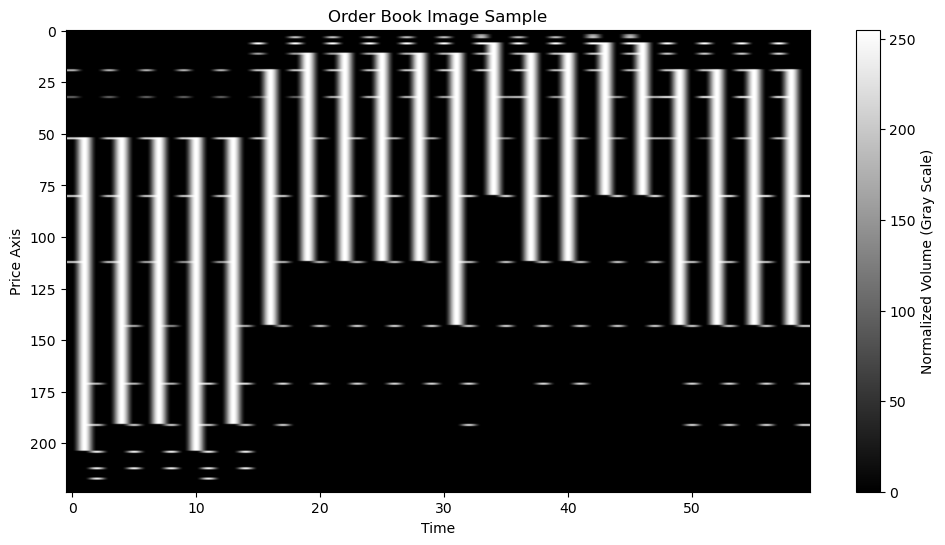

In [25]:
# visualization

def visualize_image_sample(flat_sample, REC_CNT=20):
    """
    将flatten后的图像样本可视化（224 x 3*REC_CNT）
    """
    image = flat_sample.values.reshape(224, 3*REC_CNT)
    plt.figure(figsize=(12, 6))
    plt.imshow(image, cmap='gray', aspect='auto')
    plt.title("Order Book Image Sample")
    plt.xlabel("Time")
    plt.ylabel("Price Axis")
    plt.colorbar(label="Normalized Volume (Gray Scale)")
    plt.show()

# 可视化第一个样本
visualize_image_sample(pix_df.iloc[1000, :-1], REC_CNT=REC_CNT)


# Model and Baseline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time
from datetime import datetime

import utils as _U

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# ---------------- 数据加载 -------------------
def load_data(data_folder, code_list):
    all_df = []
    for code in code_list:
        # --- csv format ---
        # file_path = os.path.join(data_folder, f"{code}.csv")
        # if os.path.exists(file_path):
        #     df = pd.read_csv(file_path)
        #     all_df.append(df)
        #     print(f"Loaded data for {file_path}: {df.shape}")

        # --- feather format ---
        file_path = os.path.join(data_folder, f"{code}.feather")
        if os.path.exists(file_path):
            df = pd.read_feather(file_path)
            all_df.append(df)
            # print(f"Loaded data for {file_path}: {df.shape}")
    return pd.concat(all_df, ignore_index=True)

# ---------------- CNN 数据预处理 -------------------
def preprocess_data_cnn(df, is_train=True):
    X = df.drop(columns=['label']).values
    y = df['label'].values
    X = X.reshape((-1, 1, 224, 60))
    
    if is_train:
        # train_set and validation_set
        return train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    else:
        return X, y


# ---------------- Baseline 数据预处理 -------------------
def preprocess_data_baseline(df, is_train=True):
    X = df.drop(columns=['label']).values
    y = df['label'].values
    return X, y

In [ ]:
# ---------------- Baseline 模型训练 -------------------
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from xgboost import XGBClassifier
from tqdm import tqdm
import time

def train_baselines(X_train, y_train, X_test, y_test):
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    results = {}

    # # === MLP ===
    # print("\nTraining MLPClassifier...")
    # start = time.time()
    # mlp = MLPClassifier(hidden_layer_sizes=(256,), max_iter=10, verbose=True)
    # mlp.fit(X_train_flat, y_train)
    # elapsed = time.time() - start
    # print(f"Time taken: {elapsed:.2f}s")
    # y_pred_mlp = mlp.predict(X_test_flat)
    # results['mlp'] = classification_report(y_test, y_pred_mlp, digits=4)
    # print("MLP:\n", results['mlp'])

    # === Random Forest ===
    print("\nTraining Random Forest...")
    start = time.time()
    rf = RandomForestClassifier(n_estimators=50, max_depth=15, n_jobs=-1, verbose=1, random_state=42)
    rf.fit(X_train_flat, y_train)
    elapsed = time.time() - start
    print(f"Time taken: {elapsed:.2f}s")
    y_pred_rf = rf.predict(X_test_flat)
    results['rf'] = classification_report(y_test, y_pred_rf, digits=4)
    print("Random Forest:\n", results['rf'])

    # === XGBoost ===
    print("\nTraining XGBoost...")
    start = time.time()
    xgb = XGBClassifier(
        max_depth=6,
        n_estimators=50,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.5,
        tree_method='hist',  # 更快
        n_jobs=-1,
        verbosity=1,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb.fit(X_train_flat, y_train)
    elapsed = time.time() - start
    print(f"Time taken: {elapsed:.2f}s")
    y_pred_xgb = xgb.predict(X_test_flat)
    results['xgb'] = classification_report(y_test, y_pred_xgb, digits=4)
    print("XGBoost:\n", results['xgb'])

    # # === Logistic Regression ===
    # print("Training Logistic Regression...")
    # start = time.time()
    # logi = LogisticRegression(max_iter=100, solver='saga', verbose=1, n_jobs=-1)
    # logi.fit(X_train_flat, y_train)
    # elapsed = time.time() - start
    # print(f"Time taken: {elapsed:.2f}s")
    # y_pred_logi = logi.predict(X_test_flat)
    # results['logi'] = classification_report(y_test, y_pred_logi, digits=4)
    # print("Logistic Regression:\n", results['logi'])

    return results


: 

In [ ]:
# ---------------- 主程序 -------------------
# if __name__ == "__main__":
train_data_folder = 'data_202111/2D_data_11-1_11-7'
train_data_folder_2 = 'data_202111/2D_data_11-8_11-14'
train_data_folder_3 = 'data_202111/2D_data_11-15_11-21'
test_data_folder = 'data_202111/2D_data_11-22_11-30'  
code_list = [
    # 中证A50十大权重
    '600519sh',  # 贵州茅台
    '300750sz',  # 宁德时代
    '601318sh',  # 中国平安
    '600036sh',  # 招商银行
    '600900sh',  # 长江电力
    '000333sz',  # 美的集团
    '002594sz',  # 比亚迪
    '601899sh',  # 紫金矿业
    '600030sh',  # 中信证券
    '600276sh',  # 恒瑞医药
]

train_df = load_data(train_data_folder, code_list)
train_df_2 = load_data(train_data_folder_2, code_list)
train_df_3 = load_data(train_data_folder_3, code_list)
train_df = pd.concat([train_df, train_df_2, train_df_3], ignore_index=True)
X_train, y_train = preprocess_data_baseline(train_df)

test_df = load_data(test_data_folder, code_list)
X_test, y_test = preprocess_data_baseline(test_df)

print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")
print(f"训练集标签分布: {np.unique(y_train, return_counts=True)}")
print(f"测试集标签分布: {np.unique(y_test, return_counts=True)}")


In [ ]:
12677/23734

0.5341282548243027

In [ ]:
print("训练并评估 Baseline 模型...")
base_results = train_baselines(X_train, y_train, X_test, y_test)
print("\n=== 模型加权 F1 对比 ===")
base_results

训练并评估 Baseline 模型...

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.8s finished


Time taken: 1.28s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


Random Forest:
               precision    recall  f1-score   support

           0     0.5776    0.5601    0.5687     12677
           1     0.5125    0.5303    0.5213     11057

    accuracy                         0.5462     23734
   macro avg     0.5451    0.5452    0.5450     23734
weighted avg     0.5473    0.5462    0.5466     23734


Training XGBoost...


/Users/liuyufei/anaconda3/envs/lob_deep_learning/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:04:37] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Time taken: 12.10s
XGBoost:
               precision    recall  f1-score   support

           0     0.5628    0.5394    0.5509     12677
           1     0.4959    0.5196    0.5075     11057

    accuracy                         0.5302     23734
   macro avg     0.5294    0.5295    0.5292     23734
weighted avg     0.5317    0.5302    0.5306     23734


=== 模型加权 F1 对比 ===
{'rf': '              precision    recall  f1-score   support\n\n           0     0.5776    0.5601    0.5687     12677\n           1     0.5125    0.5303    0.5213     11057\n\n    accuracy                         0.5462     23734\n   macro avg     0.5451    0.5452    0.5450     23734\nweighted avg     0.5473    0.5462    0.5466     23734\n', 'xgb': '              precision    recall  f1-score   support\n\n           0     0.5628    0.5394    0.5509     12677\n           1     0.4959    0.5196    0.5075     11057\n\n    accuracy                         0.5302     23734\n   macro avg     0.5294    0.5295    0.5292    

## CNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time
from datetime import datetime

import utils as _U

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

REC_CNT=20

# ---------------- 数据加载 -------------------
def load_data(data_folder, code_list, is_train=True):
    all_df = []
    for code in code_list:
        # --- feather format ---
        file_path = os.path.join(data_folder, f"{code}.feather")
        if os.path.exists(file_path):
            df = pd.read_feather(file_path)
            all_df.append(df)
            print(f"Loaded data for {file_path}: {df.shape}")

    all_df = pd.concat(all_df, ignore_index=True)
    # if is_train:  # 训练集降采样
    #     all_df = resample(all_df, n_samples=50000, random_state=42)
    
    return all_df

# ---------------- CNN 数据预处理 -------------------
def preprocess_data_cnn(df, is_train=True):
    X = df.drop(columns=['label']).values
    y = df['label'].values
    
    # 标准化到均值0，方差1
    # mean = X.mean(axis=0)
    # std = X.std(axis=0)
    # std[std == 0] = 1e-6  # 防止除以0
    # X = (X - mean) / std
    
    X = X.reshape((-1, 1, 224, 3 * REC_CNT))
    
    if is_train:
        # X_train, X_val, y_train, y_val
        return train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    else:
        return X, y


In [2]:
# ---------------- 主程序 -------------------
# if __name__ == "__main__":
train_data_folder = 'data_202111/2D_data_11-1_11-7'
# train_data_folder_2 = 'data_202111/2D_data_11-8_11-14'
# train_data_folder_3 = 'data_202111/2D_data_11-15_11-21'
test_data_folder = 'data_202111/2D_data_11-22_11-30' 

code_list = [
    # 中证A50十大权重
    '600519sh',  # 贵州茅台
    '300750sz',  # 宁德时代
    # '601318sh',  # 中国平安
    # '600036sh',  # 招商银行
    # '600900sh',  # 长江电力
    # '000333sz',  # 美的集团
    # '002594sz',  # 比亚迪
    # '601899sh',  # 紫金矿业
    # '600030sh',  # 中信证券
    # '600276sh',  # 恒瑞医药
]

train_df = load_data(train_data_folder, code_list)
# train_df_2 = load_data(train_data_folder_2, code_list)
# train_df_3 = load_data(train_data_folder_3, code_list)
# train_df = pd.concat([train_df, train_df_2, train_df_3], ignore_index=True)
X_train, X_val, y_train, y_val = preprocess_data_cnn(train_df)

test_df = load_data(test_data_folder, code_list, is_train=False)
X_test, y_test = preprocess_data_cnn(test_df, is_train=False)

print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")
print(f"训练集标签分布: {np.unique(y_train, return_counts=True)}")
print(f"测试集标签分布: {np.unique(y_test, return_counts=True)}")


Loaded data for data_202111/2D_data_11-1_11-7/600519sh.feather: (9497, 13441)
Loaded data for data_202111/2D_data_11-1_11-7/300750sz.feather: (9452, 13441)
Loaded data for data_202111/2D_data_11-22_11-30/600519sh.feather: (19017, 13441)
Loaded data for data_202111/2D_data_11-22_11-30/300750sz.feather: (18923, 13441)
训练集大小: (13264, 1, 224, 60), 测试集大小: (37940, 1, 224, 60)
训练集标签分布: (array([0, 1]), array([6711, 6553]))
测试集标签分布: (array([0, 1]), array([19762, 18178]))


In [6]:
# ---------------- CNN 模型定义 -------------------
class CNNClassifier(nn.Module):
    def __init__(self, in_channels=1):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)  # (1, 224, 60) → (16, 224, 60)
        self.pool = nn.MaxPool2d(2, 2)                                     # → (16, 112, 30)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)           # → (32, 112, 30)
        self.fc1 = nn.Linear(32 * 56 * 15, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # → (16, 112, 30)
        x = self.pool(F.relu(self.conv2(x)))  # → (32, 56, 15)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class BinaryCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(BinaryCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),   # (1, 224, 60) -> (32, 224, 60)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),                                      # -> (32, 112, 30)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),            # -> (64, 112, 30)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),                                      # -> (64, 56, 15)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),           # -> (128, 56, 15)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),                                      # -> (128, 28, 7)

            nn.Dropout(0.5)
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, 224, 60)
            dummy_out = self.features(dummy)
            self.fc_in = dummy_out.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Linear(self.fc_in, 512),
            nn.ReLU(),
            nn.Linear(512, 2)  # 对应 CrossEntropyLoss 的2类输出
        )

        # 参数初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



class BinaryCNN_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Input: [1, 224, 60]
            nn.Conv2d(1, 64, kernel_size=3, padding=1),   # -> [64, 224, 60]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d((2, 2)),                         # -> [64, 112, 30]
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # -> [128, 112, 30]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d((2, 2)),                         # -> [128, 56, 15]
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),# -> [256, 56, 15]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool2d((1, 1)),                 # -> [256, 1, 1]
            nn.Dropout(0.5)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                 # -> [256]
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2)                              # 多分类可选；二分类时改为1+sigmoid
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


class VGG7(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),   # [64, 224, 60]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),               # [64, 112, 30]

            nn.Conv2d(64, 128, 3, padding=1), # [128, 112, 30]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),               # [128, 56, 15]

            nn.Conv2d(128, 256, 3, padding=1),# [256, 56, 15]
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),     # [256, 1, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # CrossEntropyLoss
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)



# ------------- EarlyStopping 工具类 -------------
class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

# ---------------- CNN 训练 + 保存 + 绘图 -------------------
def train_cnn(model_class, X_train, y_train, X_val, y_val, epochs=20, batch_size=64, save_path="cnn_model.pt"):
    # model = CNNClassifier()
    model = model_class()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.long)),
                              batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                          torch.tensor(y_val, dtype=torch.long)),
                            batch_size=batch_size)

    train_losses = []
    val_f1s = []
    early_stopper = EarlyStopping(patience=4, delta=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # === 验证集 F1 ===
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                pred = torch.argmax(pred, dim=1).cpu().numpy()
                all_preds.extend(pred)
                all_labels.extend(yb.numpy())

        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f} | Val F1={val_f1:.4f}")

        # === EarlyStopping 检查 ===
        early_stopper(val_f1)
        if early_stopper.early_stop:
            print("触发 EarlyStopping，停止训练")
            break

    torch.save(model.state_dict(), save_path)
    print(f"模型已保存到: {save_path}")

    # === 绘图 ===
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_f1s, label='Val Weighted F1')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.title('Training Loss & Validation F1')
    plt.grid()
    plt.tight_layout()
    plt.savefig("training_plot.png")
    print("训练曲线已保存为: training_plot.png")

    return model

# ---------------- CNN 评估 -------------------
# def evaluate_cnn(model, X_val, y_val):
#     model.eval()
#     with torch.no_grad():
#         val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
#                                               torch.tensor(y_val, dtype=torch.long)),
#                                 batch_size=128)
#         all_preds = []
#         for xb, _ in val_loader:
#             preds = model(xb)
#             preds = torch.argmax(preds, dim=1).cpu().numpy()
#             all_preds.extend(preds)
#         print("CNN:")
#         print(classification_report(y_val, all_preds, digits=4))
#         return f1_score(y_val, all_preds, average='weighted')
    
# ----------- 使用训练好的模型预测并可视化对比 -------------
def predict_and_compare(model_class, model_path, X_test, y_test, n_show=100):
    # model = CNNClassifier()
    model = model_class()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.long)),
                             batch_size=128)

    all_preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            preds = model(xb)
            preds = torch.argmax(preds, dim=1).cpu().numpy()
            all_preds.extend(preds)

    print("预测结果对比 (classification_report):")
    print(classification_report(y_test, all_preds, digits=4))

    # 可视化前 n_show 条预测
    plt.figure(figsize=(12, 4))
    plt.plot(range(n_show), y_test[:n_show], label='True Label', marker='o')
    plt.plot(range(n_show), all_preds[:n_show], label='Predicted', marker='x')
    plt.xlabel('Sample Index')
    plt.ylabel('Class')
    plt.title(f'True vs Predicted Labels (前 {n_show} 个)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig("prediction_comparison.png")
    print("预测对比图已保存为: prediction_comparison.png")


开始训练 CNN...


Epoch 1/20: 100%|██████████| 208/208 [05:00<00:00,  1.44s/it]


Epoch 1: Loss=0.6948 | Val F1=0.5168


Epoch 2/20: 100%|██████████| 208/208 [03:32<00:00,  1.02s/it]


Epoch 2: Loss=0.6899 | Val F1=0.5187


Epoch 3/20: 100%|██████████| 208/208 [03:35<00:00,  1.04s/it]


Epoch 3: Loss=0.6873 | Val F1=0.4655
EarlyStopping counter: 1 / 4


Epoch 4/20: 100%|██████████| 208/208 [03:28<00:00,  1.00s/it]


Epoch 4: Loss=0.6816 | Val F1=0.3502
EarlyStopping counter: 2 / 4


Epoch 5/20: 100%|██████████| 208/208 [03:28<00:00,  1.00s/it]


Epoch 5: Loss=0.6813 | Val F1=0.3630
EarlyStopping counter: 3 / 4


Epoch 6/20: 100%|██████████| 208/208 [03:28<00:00,  1.00s/it]


Epoch 6: Loss=0.6782 | Val F1=0.5241


Epoch 7/20: 100%|██████████| 208/208 [03:27<00:00,  1.00it/s]


Epoch 7: Loss=0.6774 | Val F1=0.3868
EarlyStopping counter: 1 / 4


Epoch 8/20: 100%|██████████| 208/208 [03:27<00:00,  1.00it/s]


Epoch 8: Loss=0.6773 | Val F1=0.4419
EarlyStopping counter: 2 / 4


Epoch 9/20: 100%|██████████| 208/208 [03:27<00:00,  1.00it/s]


Epoch 9: Loss=0.6750 | Val F1=0.5350


Epoch 10/20: 100%|██████████| 208/208 [03:26<00:00,  1.01it/s]


Epoch 10: Loss=0.6737 | Val F1=0.3716
EarlyStopping counter: 1 / 4


Epoch 11/20: 100%|██████████| 208/208 [03:34<00:00,  1.03s/it]


Epoch 11: Loss=0.6734 | Val F1=0.3564
EarlyStopping counter: 2 / 4


Epoch 12/20: 100%|██████████| 208/208 [03:38<00:00,  1.05s/it]


Epoch 12: Loss=0.6720 | Val F1=0.4633
EarlyStopping counter: 3 / 4


Epoch 13/20: 100%|██████████| 208/208 [05:20<00:00,  1.54s/it]


Epoch 13: Loss=0.6713 | Val F1=0.3918
EarlyStopping counter: 4 / 4
触发 EarlyStopping，停止训练
模型已保存到: cnn_model.pt
训练曲线已保存为: training_plot.png


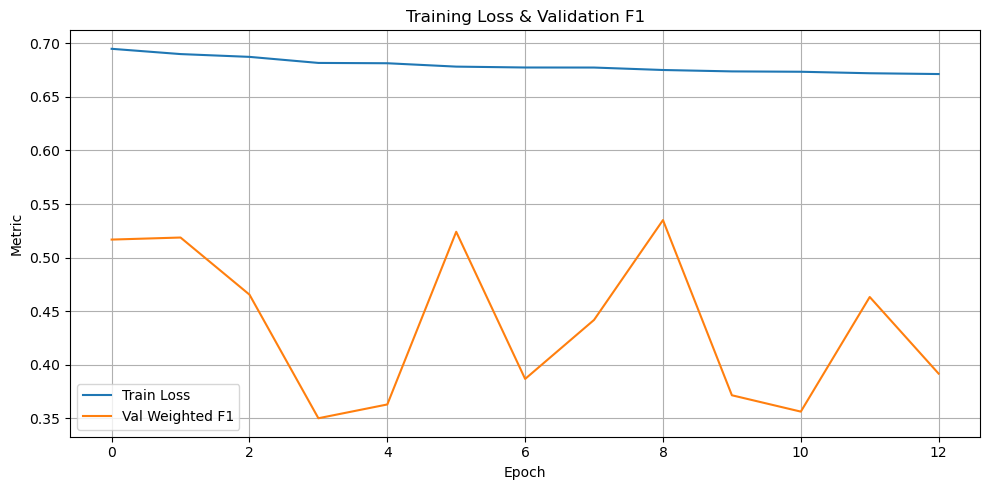

In [7]:

print("开始训练 CNN...")
cnn_model = train_cnn(BinaryCNN_2, X_train, y_train, X_val, y_val)


评估 CNN...
预测结果对比 (classification_report):
              precision    recall  f1-score   support

           0     0.5258    0.9784    0.6840     19762
           1     0.6346    0.0407    0.0765     18178

    accuracy                         0.5292     37940
   macro avg     0.5802    0.5096    0.3803     37940
weighted avg     0.5780    0.5292    0.3929     37940



/var/folders/_4/n_qyfqy95vz7996g0tcpc_kr0000gn/T/ipykernel_84614/390175643.py:266: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  plt.tight_layout()
/var/folders/_4/n_qyfqy95vz7996g0tcpc_kr0000gn/T/ipykernel_84614/390175643.py:266: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  plt.tight_layout()
/var/folders/_4/n_qyfqy95vz7996g0tcpc_kr0000gn/T/ipykernel_84614/390175643.py:267: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  plt.savefig("prediction_comparison.png")
/var/folders/_4/n_qyfqy95vz7996g0tcpc_kr0000gn/T/ipykernel_84614/390175643.py:267: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  plt.savefig("prediction_comparison.png")
/Users/liuyufei/anaconda3/envs/lob_deep_learning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  fig

预测对比图已保存为: prediction_comparison.png


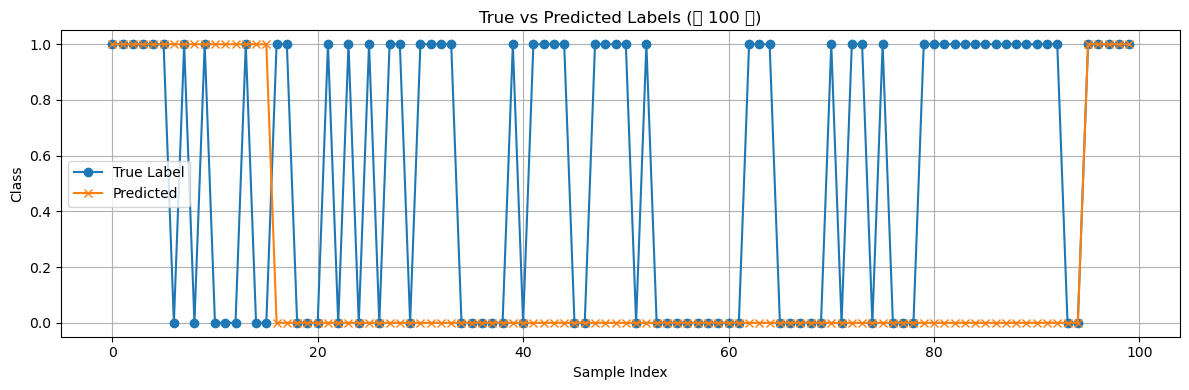

In [8]:
print("评估 CNN...")
# f1_cnn = evaluate_cnn(cnn_model, X_test, y_test)
# print(f"验证集加权 F1: {f1_cnn:.4f}")

# print("\n用训练好的 CNN 模型预测并对比结果...")
predict_and_compare(BinaryCNN_2, "cnn_model.pt", X_test, y_test)

开始训练 CNN...


Epoch 1/1: 100%|██████████| 208/208 [05:18<00:00,  1.53s/it]


Epoch 1: Loss=0.7450 | Val F1=0.3399
模型已保存到: cnn_model.pt
训练曲线已保存为: training_plot.png


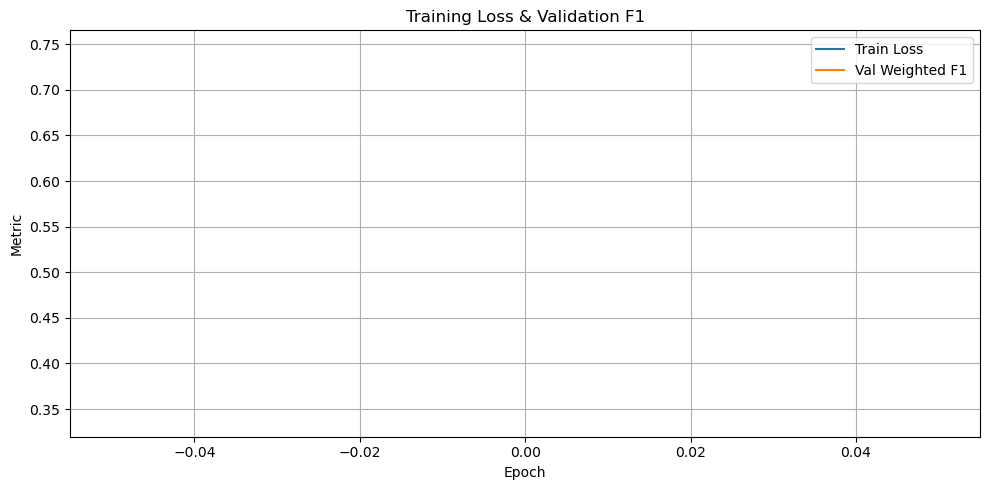

In [10]:

print("开始训练 CNN...")
cnn_model = train_cnn(VGG7, X_train, y_train, X_val, y_val, epochs=1)

评估 CNN...
预测结果对比 (classification_report):
              precision    recall  f1-score   support

           0     0.5209    1.0000    0.6850     19762
           1     0.0000    0.0000    0.0000     18178

    accuracy                         0.5209     37940
   macro avg     0.2604    0.5000    0.3425     37940
weighted avg     0.2713    0.5209    0.3568     37940



/Users/liuyufei/anaconda3/envs/lob_deep_learning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyufei/anaconda3/envs/lob_deep_learning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyufei/anaconda3/envs/lob_deep_learning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

预测对比图已保存为: prediction_comparison.png


/Users/liuyufei/anaconda3/envs/lob_deep_learning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/liuyufei/anaconda3/envs/lob_deep_learning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


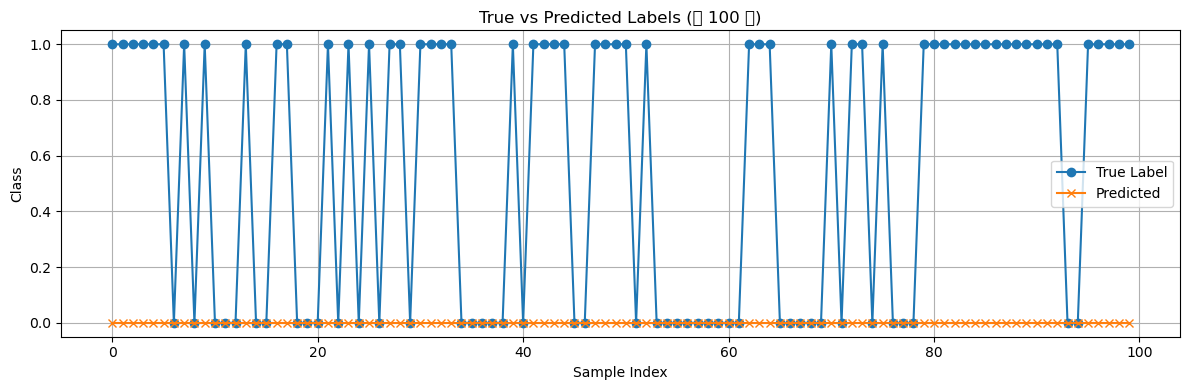

In [11]:
print("评估 CNN...")
predict_and_compare(VGG7, "cnn_model.pt", X_test, y_test)